In [1]:
import maestroflame

In [2]:
#this is the path to your data files
data_path = '../../data/data1/flame/'

#These is the input/output prefix of your datafile names.
input_prefix = 'react_inputs_*'
output_prefix = 'react_outputs_*'

#Plotfile prefixes, used for visualization purposes.
plotfile_prefix = 'flame_*'

#By default, this package will save your model, logs of the training and testing data during training,
#and plots to a directory. Here you specify that directory.
output_dir = 'testing123/'

#The log file. Everything that is printed during training also goes into this file in case something
#gets interrupted.
log_file = output_dir + "log.txt"

In [3]:
#We first remove the directory we just generated. If you don't do this you'll get an error. This is to protect
#this package from overwriting your data in case one forgets to change the output_dir when training a new model

!rm -r testing123/

In [4]:
from maestroflame.train import NuclearReactionML
nrml = NuclearReactionML(data_path, input_prefix, output_prefix, plotfile_prefix,
                output_dir, log_file, DEBUG_MODE=True, DO_PLOTTING=True,
                SAVE_MODEL=True, DO_HYPER_OPTIMIZATION=False)

Model starting on : 09/17/2021 19:07:45
input_prefix react_inputs_*
output_prefix react_outputs_*
output_dir testing123/
DEBUG_MODE True
DO_PLOTTING True
DO_HYPER_OPTIMIZATION False
Loading Input Files...
Loading Output Files...
Loaded data successfully!


In [5]:
#the package provides preset up loss functions and networks to use
from maestroflame.losses import log_loss
from maestroflame.networks import Net
import torch.optim as optim

num_epochs = 2
model = Net(16, 16, 16, 16, 14)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

nrml.train(model, optimizer, num_epochs, log_loss)

Cost at epoch 0 is 26.75290916164073
Cost at epoch 1 is 2.248337473997599


In [6]:
nrml.plot()

Plotting...


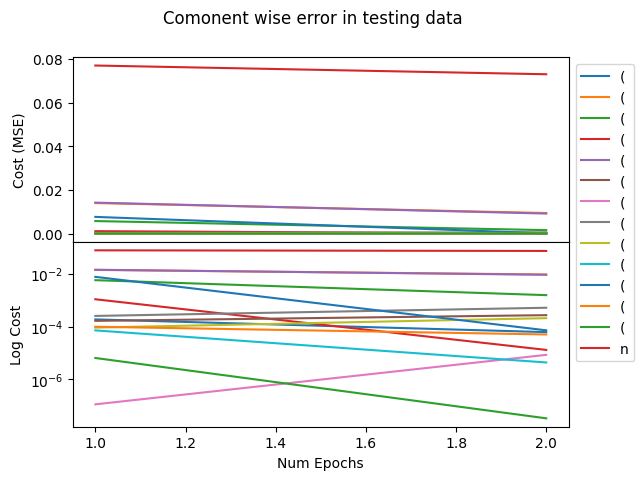

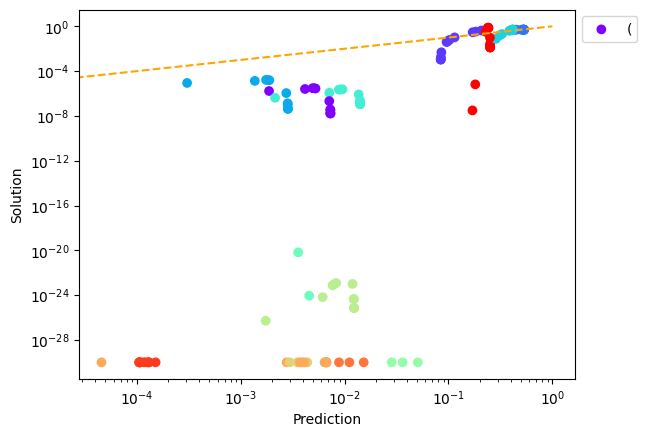

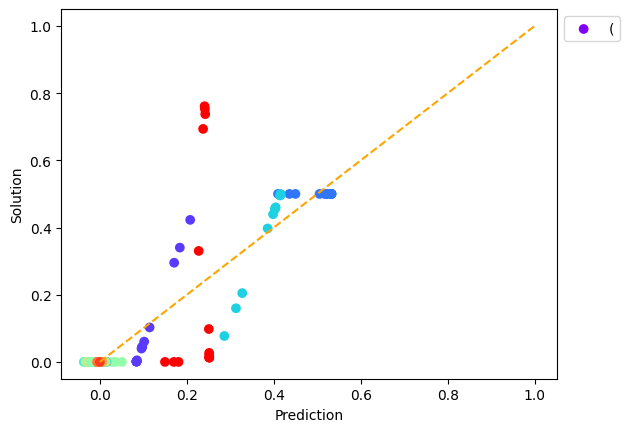

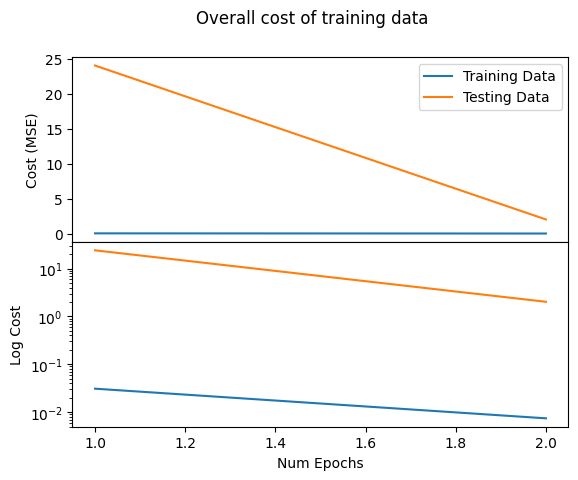

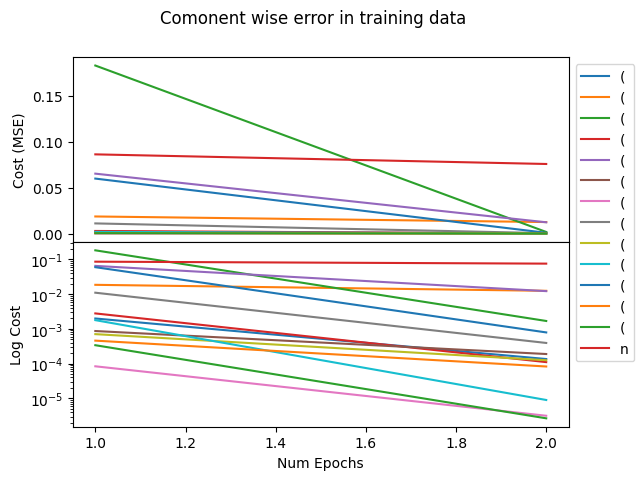

In [18]:
import glob
plots = glob.glob('testing123/*.png')
from IPython.display import Image, display

for plot in plots:
    fig = Image(filename=(plot))
    display(fig)

# The pinn class has the exact same interface.

In [22]:
data_path = '../../data/data3/flame/'
input_prefix = 'react_inputs_*'
output_prefix = 'react_outputs_*'
plotfile_prefix = 'flame_*'
output_dir = 'testing123/'
log_file = output_dir + "log.txt"

In [23]:
#We first remove the directory we just generated. If you don't do this you'll get an error. This is to protect
#this package from overwriting your data in case one forgets to change the output_dir when training a new model
!rm -r testing123/

In [24]:
from maestroflame.train import NuclearReactionPinn
nrml = NuclearReactionPinn(data_path, input_prefix, output_prefix, plotfile_prefix,
                output_dir, log_file, DEBUG_MODE=True, DO_PLOTTING=True,
                SAVE_MODEL=True, DO_HYPER_OPTIMIZATION=False)

Model starting on : 09/17/2021 19:12:30
input_prefix react_inputs_*
output_prefix react_outputs_*
output_dir testing123/
DEBUG_MODE True
DO_PLOTTING True
DO_HYPER_OPTIMIZATION False
Loading Input Files...
Loading Output Files...
Loaded data successfully!


In [26]:
#A much more complicated loss function

import torch.nn as nn
from maestroflame.losses import component_loss_f, loss_pinn, rms_weighted_error
from maestroflame.losses import log_loss, loss_mass_fraction, component_loss_f_L1, relative_loss
from maestroflame.losses import derivative_loss_piecewise, signed_loss_function

nnuc=13

def criterion(data, pred, dXdt, actual):
    #I still don't understand this one but i think don does
    #loss1 = rms_weighted_error(pred, actual[:, :nnuc+1], actual[:, :nnuc+1])

    # #difference in state variables vs prediction.
    # loss1 = log_loss(pred, actual[:, :nnuc+1])
    # #physics informed loss
    # loss2 = loss_pinn(data, pred, actual, enuc_fac, enuc_dot_fac, log_option=True)
    # #sum of mass fractions must be 1
    # loss3 = loss_mass_fraction(pred)
    # #relative loss function.
    # loss4 = relative_loss(pred, actual[:, :nnuc+1])


    #difference in state variables vs prediction.
    loss1 = log_loss(pred, actual[:, :nnuc+1])
    #scaled rates (pinn part) This only scales the magnitude of rates
    #loss2 = derivative_loss_piecewise(dXdt, actual[:, nnuc+1:], enuc_fac, enuc_dot_fac)
    L = nn.L1Loss()
    loss2 = L(dXdt, actual[:, nnuc+1:])

    #here we learn the sign of rates to make up for not doing that in loss2
    loss3 = signed_loss_function(dXdt, actual[:, nnuc+1:])
    #relative loss function. Helps disginguish between same errors of different
    #scales since we're scaling the loss2 so heavily
    loss4 = relative_loss(pred, actual[:, :nnuc+1])
    #sum of mass fractions must be 1
    loss5 = loss_mass_fraction(pred)
    #sum of rates must be 0
    #loss6 = loss_rates_mass_frac(dXdt, actual[:, nnuc+1:])

    # loss_arr = [loss1.item(), loss2.item(), loss3.item(), loss4.item(), loss5.item()]
    # return  loss1 + loss2 + loss3  + loss4 + loss5, loss_arr
    loss_arr = [loss1.item(), loss2.item(), loss3.item(), loss5.item()]
    return  loss1 + loss2 + loss3 + loss5, loss_arr

In [27]:
from maestroflame.networks import Net
import torch.optim as optim

num_epochs = 2
model = Net(16, 16, 16, 16, 14)
optimizer = optim.Adam(model.parameters(), lr=1e-6)

nrml.train(model,optimizer, num_epochs, criterion)

Cost at epoch 0 is 325.0269722964257
Cost at epoch 1 is 267.35573024399974
Saving...


In [28]:
nrml.plot()

Plotting...


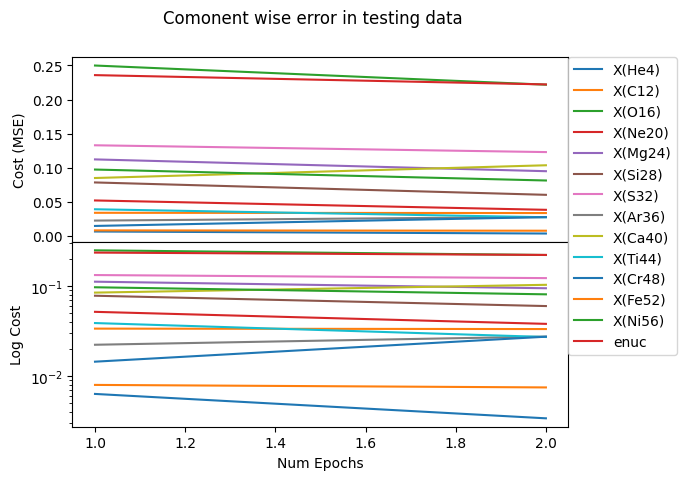

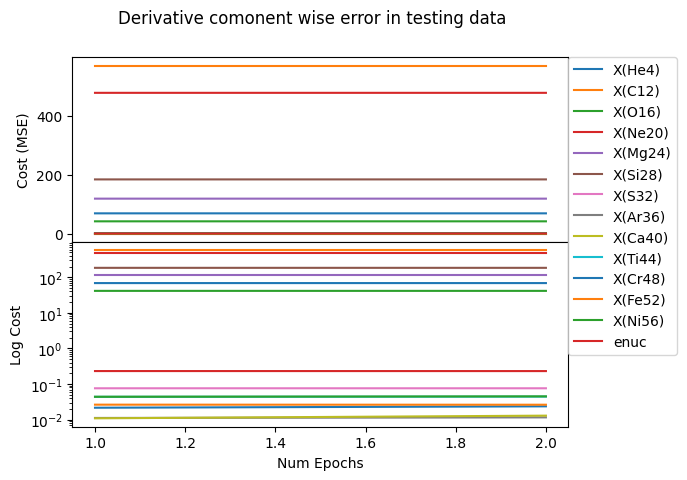

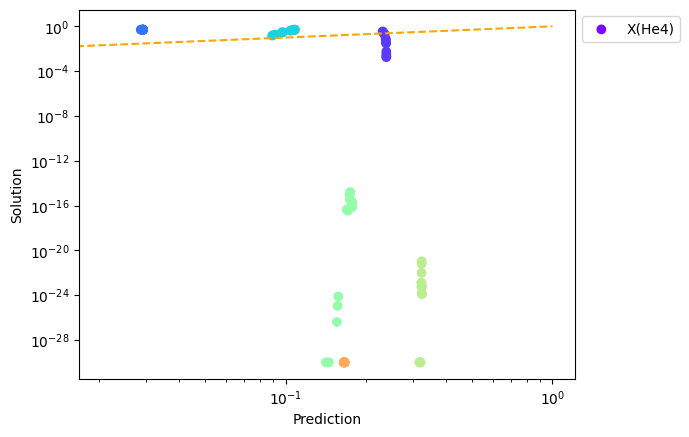

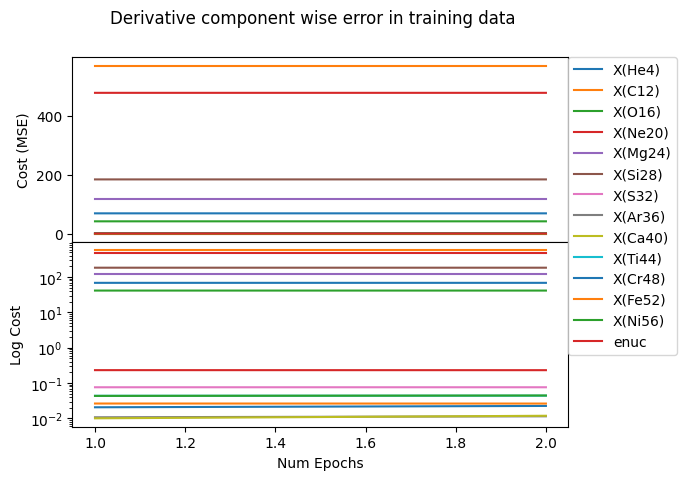

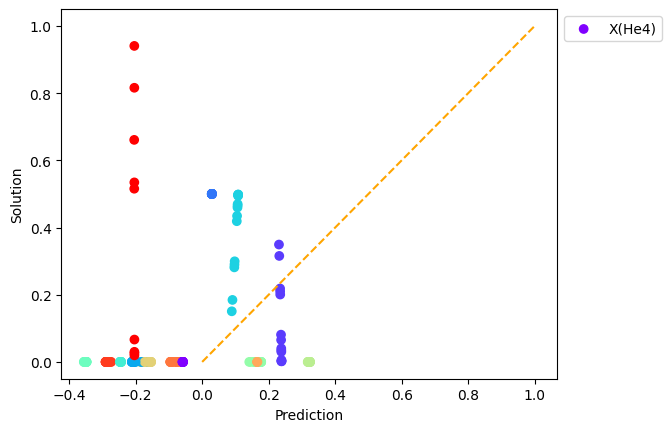

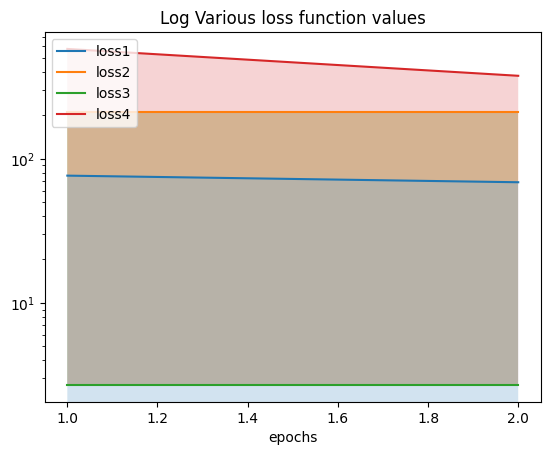

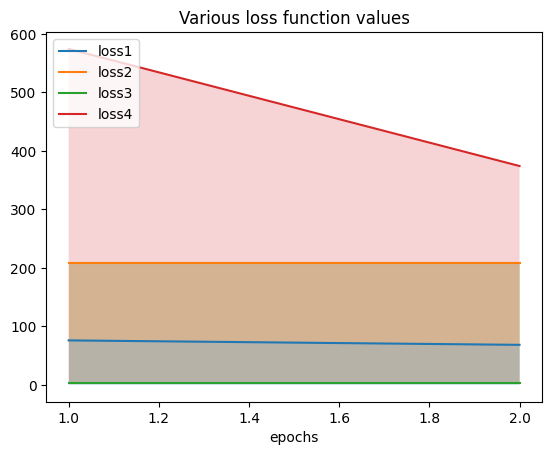

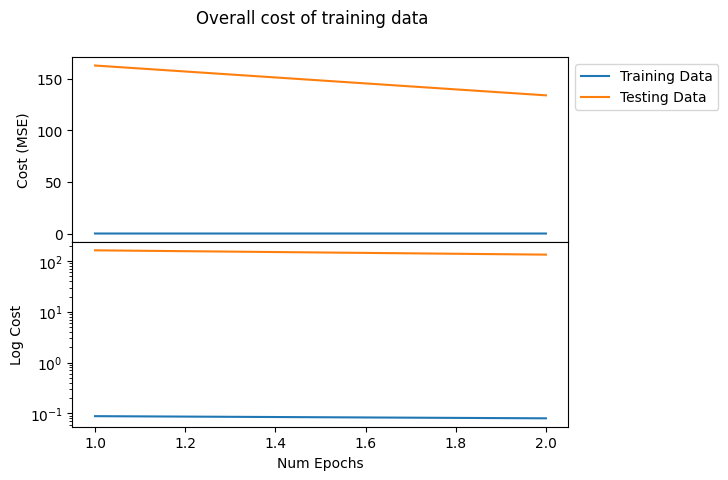

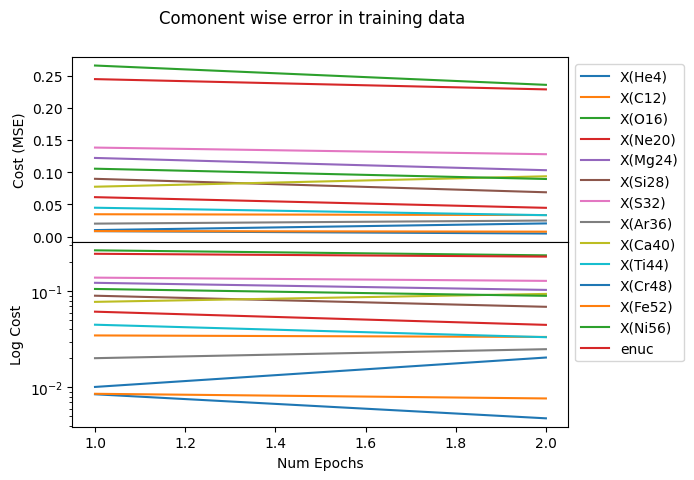

In [29]:
import glob
plots = glob.glob('testing123/*.png')
from IPython.display import Image, display

for plot in plots:
    fig = Image(filename=(plot))
    display(fig)